# Whitewater Accidents Time-Series

## The database
A static dataset was exported from the database on February 3, 2021. A fresh export can be gotten at this link:
https://www.americanwhitewater.org/content/Accident/export-db/

The export service passes back the following

```
- accident.zip
    - tmp
        - accidentGgcRaI.dir
            - accidents.csv
            - accidents_causes.csv
            - accidents_factors.csv
            - causes.csv
            - factors.csv
            - injuries.csv
```

Each labeled column is duplicated within a column with a number label. I.e., the `accident_date` column is duplicated in another column labeled `1`, column `revision` == column `29`, etc.

Causes, factors, and injuries are all split out by lookup tables, and there can be multiple causes, factors, and injuries associated with each row.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
retrieval_date = datetime(2021,2,3)

In [4]:
def save_png(figure, png_path):
    
    print(f'Saving PNG {png_path}')
    figure.savefig(png_path, bbox_inches='tight', pad_inches=0.3, dpi=72, facecolor='w')
    plt.close(figure) # comment out if you want outputs on the screen

In [43]:
def remove_int_columns(_df:pd.DataFrame) -> pd.DataFrame:
    """A brute force approach to removing integer columns."""
    keep_list = []
    for column in _df.columns:
        try:
            int(column)
        except:
            keep_list.append(column)
            
    return _df[keep_list]

In [44]:
accident = remove_int_columns(pd.read_csv("../database/latest/accidents.csv", index_col="id"))
accident_cause = remove_int_columns(pd.read_csv("../database/latest/accidents_causes.csv", index_col="accident_id"))
accident_factor = remove_int_columns(pd.read_csv("../database/latest/accidents_factors.csv", index_col="accident_id"))
accident_injury = remove_int_columns(pd.read_csv("../database/latest/accidents_injuries.csv", index_col="accident_id"))
cause_lookup = remove_int_columns(pd.read_csv("../database/latest/causes.csv", index_col="id"))
factor_lookup = remove_int_columns(pd.read_csv("../database/latest/factors.csv", index_col="id"))
injury_lookup = remove_int_columns(pd.read_csv("../database/latest/injuries.csv", index_col="id"))

causes = accident_cause.join(cause_lookup, how='left', on='cause_id')
factors = accident_factor.join(factor_lookup, how='left', on='factor_id')
injuries = accident_injury.join(injury_lookup, how='left', on='injury_id')

## Time series

In [66]:
ts = accident.copy()
ts['accident_date'] = pd.to_datetime(ts['accident_date'], format='%Y-%m-%d')
ts = ts.dropna(subset = ['accident_date'])
ts = ts.sort_values('accident_date')

# there are a few accidents with typos in the dates (e.g., "2089")
ts = ts[~(ts['accident_date'] > retrieval_date)]

In [80]:
year_ts = ts.groupby(pd.Grouper(key = 'accident_date', freq='Y')).count()['victim_name']
year_ts.index.name = ''
year_ts.name = 'Count'

In [154]:
def timeseries_bar_plot(years, values, title=""):
    
    fig = plt.figure(figsize=(16,4))
    ax = fig.add_axes([0,0,1,1])

    ax.bar(years, values, width=0.96, color='#aaaaaa')

    ax.tick_params(axis='y', labelsize=16, length=0, pad=10)
    ax.tick_params(axis='x', labelsize=18, length=0, pad=10)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(True)

    ax.grid(axis='x', color='#dddddd', linewidth=2)
    ax.set_axisbelow(True)
    ax.set_xlim([1974, 2020.5])
    ax.set_ylim([0, 130])

    ax.set_title(title, fontsize=36, fontweight='bold', loc='left', pad=20)
    
    sources_text = (
        f"Source: American Whitewater Accident Database retrieved on {retrieval_date.strftime('%b %d, %Y')}"
    )
    plt.figtext(0.0, -0.15, sources_text, ha="left", va='top', fontsize=12, linespacing=1.5, color='#555555')
    
    return fig

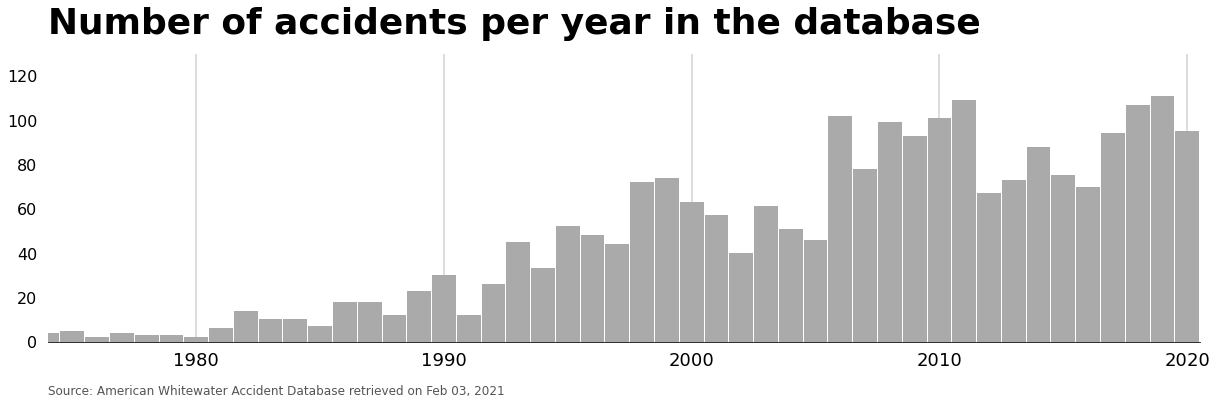

In [159]:
ts_plot = timeseries_bar_plot(year_ts.index.year, year_ts.values, title="Number of accidents per year in the database")

In [160]:
save_png(ts_plot, "../outputs/latest-ts-count.png")

Saving PNG ../outputs/latest-ts-count.png
